In [ ]:
  pip install py_vollib

     |████████████████████████████████| 133kB 10.3MB/s 
  Created wheel for py-vollib: filename=py_vollib-1.0.1-cp36-none-any.whl size=62859 sha256=cd82866f8ad2543b5ddbb2debd22502d092df95bc10ae9c13743bc269b651976
  Stored in directory: /root/.cache/pip/wheels/31/7f/5d/abd43b8427abf03acc59e688fb8e411b8108a937398966894f
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-cp36-none-any.whl size=24467 sha256=f9d53f7a56390d9583b7236be0809afecd9a4562fc838b11780c968e76267972
  Stored in directory: /root/.cache/pip/wheels/b5/47/7d/db68726417a2ca3ed6bdc904a1376e26774fad9ea72e0cc159
Successfully built py-vollib py-lets-be-rational


In [ ]:
import pandas as pd
import numpy as np
import py_vollib.black_scholes as BSM
import scipy.stats as sci
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename = "../isx2010C.xls"

In [ ]:
# Function for importing option-data as dataframe
def sheet_as_dataframe(filename, sheetname):
  df = pd.read_excel(io = filename, header = 0, sheet_name = sheetname)
  df.rename({df.columns[0]:"Maturity", df.columns[len(df.columns)-3]: "S", df.columns[len(df.columns)-2]: "r", df.columns[len(df.columns)-1]: "Date"}, \
            axis = "columns", inplace = True)
  df.set_index("Maturity", inplace = True)
  df.dropna(axis = 0, how = "all", inplace = True)
  # Change all values to numeric or NaN

  for col in df.columns:
    if col != df.columns[len(df.columns)-1]:
      df[col] = pd.to_numeric(df[col], errors='coerce')
      
  return df

In [ ]:
# Help function to sort sheets by date
def sort_help_function(df):
  date = df.iloc[len(df.index)-1, len(df.columns)-1]
  date = date.replace(".", "")
  date = datetime.strptime(date, "%d%m%Y").date()
  return date

In [ ]:
# Function for loading all spreadsheets from a excel file into list of spreadsheets
def excel_file_as_dfs(filename):
  sheets = []
  files = pd.read_excel(io = filename, sheet_name = None)
  for key, value in files.items():
    sheets.append(sheet_as_dataframe(filename, key))
  sheets.sort(key = sort_help_function)
  return sheets

In [ ]:
# Calculating implied volatility from given df, call price strike price and maturity using Newton's method
def implied_vola(strike_price, stock_price, call_price, maturity, risk_free_interest, MAX_ERR, MAX_ITER):
  sigma = 0.5 # initial guess
  call_price = float(str(call_price).replace(",", "."))
 
  for i in range(0, MAX_ITER):
    d1 = (np.log(stock_price/strike_price) + (risk_free_interest+sigma ** 2 / 2) * maturity) / (sigma * np.sqrt(maturity))
    call_price1 = BSM.black_scholes("c", stock_price, strike_price, maturity, risk_free_interest, sigma)
    vega = stock_price * np.sqrt(maturity) * sci.norm.cdf(d1, 0.0, 1.0)
    difference = float(call_price) - float(call_price1)
    
    if (abs(difference) < MAX_ERR):
      return sigma
    sigma = sigma + difference / vega
  return sigma
  

  BSM.implied_volatility(price, S, K, t, r, flag)


In [ ]:
# Delta hedging for a single option for single spreadsheet. Returns mean squared error for hedging
def delta_hedge(filename, maturity, hedging_frequency, strike_price):
  
  dfs = excel_file_as_dfs(filename)
  A = []
  rep_df_index = 0
  for df in dfs:

    # Select rows in df that come after selected maturity date
    subdf = df[df.index <= maturity]

    # To keep up with whether to hedge or not
    hedge_day_counter= 0

    # To store values of previous sigma and delta if not time to hedge
    prev_sigma, prev_delta = 0, 0
    
    OP, RE = [], []

    # counter for indexing OP, A and RE
    i = 0

    first_day = True

    # Loop through rows in option data
    for index, row in subdf.iterrows():
      HEDGE = False
      S = row["S"]
      C = row[strike_price]
      maturity_year = index/365
      r = row["r"]/100

      if hedge_day_counter == 0:
        HEDGE = True
        hedge_day_counter = hedging_frequency
    
      # if time to hedge, calculate new delta
      if HEDGE:
        sigma = implied_vola(strike_price, S, C, maturity_year, r, 0.001, 100)
        d1 = (np.log(S/strike_price) + (r + sigma ** 2 / 2) * maturity_year) / (sigma * np.sqrt(maturity_year))

        delta = sci.norm.cdf(d1, 0.0, 1.0)

        prev_delta = delta
        prev_sigma = sigma
      
      # if not, use previous values
      else:
        delta = prev_delta
        sigma = prev_sigma

      # store values for later use
      OP.append(C)
      RE.append(S*delta)
      
      # if not first day, count A
      
      if first_day:
        first_day = False
      
      else:  
        a = OP[i] - OP[i-1] - (RE[i]- RE[i-1])
        A.append(a)

      hedge_day_counter -= 1
      i += 1
  return np.nanmean(np.square(A)), np.nanstd(np.square(A))
    


In [ ]:
err = delta_hedge(filename, 45, 3, 480)
print(err)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWa

(819.4896990265458, 3993.2944556458415)


In [ ]:
# Idea is similar to delta hedging single option

def delta_hedge_portfolio(filename, maturity, hedging_frequency, strike_prices):
   
  dfs = excel_file_as_dfs(filename)
  # Select rows in df that come after selected maturity date
  A_all = {}

  for strike_price in strike_prices:
    A_all[strike_price] = []

  for df in dfs:  
    subdf = df[df.index <= maturity]

    for strike_price in strike_prices:

      # To keep up with whether to hedge or not
      HEDGE = False
      hedge_day_counter= 0

      # To store values of previous sigma and delta if not time to hedge
      prev_sigma, prev_delta = 0, 0
      
      OP, A, RE = [], [], []

      # counter for indexing OP, A and RE
      i = 0

      first_day = True

      # Loop through rows in option data
      for index, row in subdf.iterrows():
        HEDGE = False
        S = row["S"]
        C = row[strike_price]
        maturity_year = index/365
        r = row["r"]/100

        if hedge_day_counter == 0:
          HEDGE = True
          hedge_day_counter = hedging_frequency
      
        # if time to hedge, calculate new delta
        if HEDGE:
          sigma = implied_vola(strike_price, S, C, maturity_year, r, 0.001, 100)
          d1 = (np.log(S/strike_price) + (r + sigma ** 2 / 2) * maturity_year) / (sigma * np.sqrt(maturity_year))

          delta = sci.norm.cdf(d1, 0.0, 1.0)

          prev_delta = delta
          prev_sigma = sigma
        
        # if not, use previous values
        else:
          delta = prev_delta
          sigma = prev_sigma

        # store values to calculate A
        OP.append(C)
        RE.append(S*delta)
        
        # if not first day, count A
        
        if first_day:
          first_day = False
        
        else:  
          a = OP[i] - OP[i-1] - (RE[i]- RE[i-1])
          A_all[strike_price].append(a)

          hedge_day_counter -= 1
          i += 1
  A_all_sum = A_all[strike_prices[0]]
  for i in range(1, len(strike_prices)):
    A_all_sum = np.add(A_all_sum, A_all[strike_prices[i]])

  return np.nanmean(np.square(A_all_sum)), np.nanstd(np.square(A_all_sum))


In [ ]:
err = delta_hedge_portfolio(filename, 45, 3, [480, 500, 520])
print(err)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWa

(47418.518975362735, 397955.2070999052)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value e

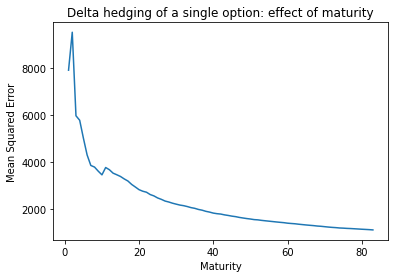

In [ ]:
# Kuvaajia
# Maturity muutos delta hedging
averages = []
stds = []
maturities = []

  
for maturity in range(1, 85):
  average, std = delta_hedge(filename, int(maturity), 3, 500)
  stds.append(std)
  averages.append(average)
  maturities.append(maturity)

plt.xlabel("Maturity")
plt.ylabel("Mean Squared Error")
plt.title("Delta hedging of a single option: effect of maturity")
plt.plot(averages)

# Eri rehedgaus väleillä
# Eri strike price



In [ ]:
def delta_vega_hedge(filename, maturity, hedging_frequency, strike_price):
  dfs = excel_file_as_dfs(filename)
  A = []
  
  rep_df_index = 0
  # Looping through all sheets in df and counting total A
  for df in dfs:
    rep_df_index += 1
    # Select rows in df that come after selected maturity date
    if rep_df_index < len(dfs):

      rep_df = dfs[rep_df_index]

      subdf = df[df.index <= maturity]

      # To keep up with whether to hedge or not
      HEDGE = False
      hedge_day_counter= 0

      # To store values of previous sigma, delta,  if not time to hedge
      prev_sigma, prev_delta, prev_vega, prev_sigma_rep, prev_delta_rep, prev_vega_rep = 0, 0, 0, 0, 0, 0
      
      underlyings, reps, calls = [], [], []

      # counter for indexing options, reps and stocks
      i = 0

      first_day = True

      # Loop through rows in option data
      for index, row in subdf.iterrows():
 
        HEDGE = False
        S = row["S"]
        C = row[strike_price]
        maturity_year = index/365
        r = row["r"]/100
        
        subdf_rep = rep_df.loc[rep_df["Date"] == row["Date"]]
        
        C_rep = np.nan
        maturity_year_rep = np.nan

        for index, rep_row in subdf_rep.iterrows():
          C_rep = rep_row[strike_price]
          maturity_year_rep = index/365

        if hedge_day_counter == 0:
          HEDGE = True
          hedge_day_counter = hedging_frequency
      
        # if time to hedge, calculate new delta and vega
        if HEDGE:
          sigma = implied_vola(strike_price, S, C, maturity_year, r, 0.001, 100)
          sigma_rep = implied_vola(strike_price, S, C_rep, maturity_year_rep, r, 0.001, 100)
          d1 = (np.log(S/strike_price) + (r + sigma ** 2 / 2) * maturity_year) / (sigma * np.sqrt(maturity_year))
          d1_rep = d1 = (np.log(S/strike_price) + (r + sigma_rep ** 2 / 2) * maturity_year_rep) / (sigma_rep * np.sqrt(maturity_year_rep))

          delta = sci.norm.cdf(d1, 0.0, 1.0)  
          delta_rep = delta = sci.norm.cdf(d1_rep, 0.0, 1.0)  

          vega = S * np.sqrt(maturity_year) * sci.norm.pdf(d1, 0.0, 1.0)
          vega_rep = S * np.sqrt(maturity_year_rep) * sci.norm.pdf(d1_rep, 0.0, 1.0)

          prev_delta = delta
          prev_sigma = sigma
          prev_vega = vega

          prev_delta_rep = delta_rep
          prev_sigma_rep = sigma_rep
          prev_vega_rep = vega_rep
        
        # if not, use previous values
        else:
          delta = prev_delta 
          sigma = prev_sigma 
          vega = prev_vega

          delta_rep = prev_delta_rep
          sigma_rep = prev_sigma_rep
          vega_rep = prev_vega_rep

        # Count alpha and eta and store values for later use
        alpha = -1 * delta + (vega / vega_rep ) * delta_rep
        eta = -1 * vega / vega_rep
        
        underlyings.append(alpha*S)
        calls.append(C)
        reps.append(eta * C_rep)

        # if not first day, count A
        
        if first_day:
          first_day = False
        
        else:  
          a = calls[i] - calls[i-1] - (underlyings[i]- underlyings[i-1]) - (reps[i] - reps[i-1])
          A.append(a)

        hedge_day_counter -= 1
        i += 1

  return np.nanmean(np.square(A)), np.nanstd(np.square(A))

In [ ]:
err = delta_vega_hedge(filename, 45, 2, 500)
print(err)

(118.80427365315686, 546.9536817633742)


In [ ]:
averages = []
stds = []
maturities = []

  
for maturity in range(3, 60):
  average, std = delta_vega_hedge(filename, 45 ,2, 480)
  stds.append(std)
  averages.append(average)
  maturities.append(maturity)

# plt.xlabel("Maturity")
# plt.ylabel("Mean Squared Error")
# plt.title("Delta hedging of a single option: effect of maturity")
# plt.plot(averages)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWa

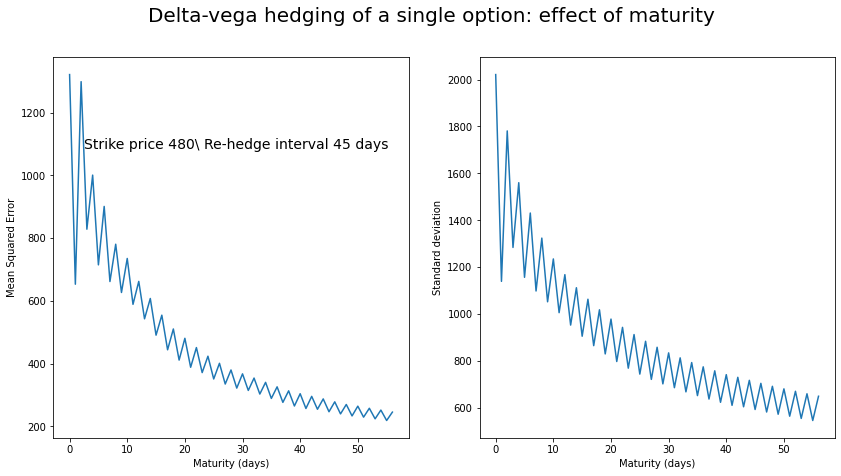

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Delta-vega hedging of a single option: effect of maturity', fontsize=20)

ax1.set(xlabel="Maturity (days)", ylabel="Mean Squared Error")
ax1.plot(averages)
ax1.annotate('Strike price 480\ Re-hedge interval 45 days',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 300), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='top', fontsize=14)

ax2.set(xlabel="Maturity (days)", ylabel="Standard deviation")
ax2.plot(stds)

In [ ]:
averages = []
stds = []
freqs = []

  
for freq in range(1, 20):
  average, std = delta_vega_hedge(filename, 45 , freq, 480)
  stds.append(std)
  averages.append(average)
  freqs.append(freq)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWa

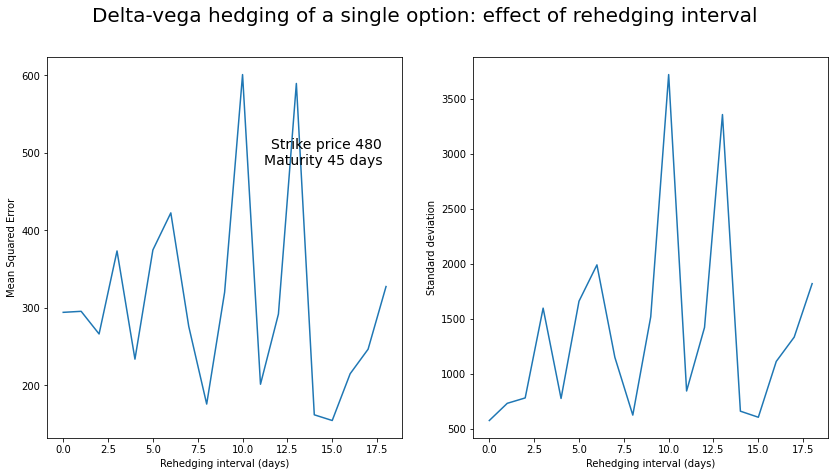

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Delta-vega hedging of a single option: effect of rehedging interval', fontsize=20)

ax1.set(xlabel="Rehedging interval (days)", ylabel="Mean Squared Error")
ax1.plot(averages)
ax1.annotate('Strike price 480\nMaturity 45 days',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 300), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='top', fontsize=14)

ax2.set(xlabel="Rehedging interval (days)", ylabel="Standard deviation")
ax2.plot(stds)

In [ ]:
averages_delta = []
stds_delta = []
maturities_delta = []

averages_vega = []
stds_vega = []
maturities_vega = []

  
for maturity in range(3, 60):
  average_delta, std_delta = delta_hedge(filename, maturity ,2, 480)
  stds_delta.append(std_delta)
  averages_delta.append(average_delta)
  average_vega, std_vega = delta_vega_hedge(filename, maturity ,2, 480)
  stds_vega.append(std_vega)
  averages_vega.append(average_vega)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWa

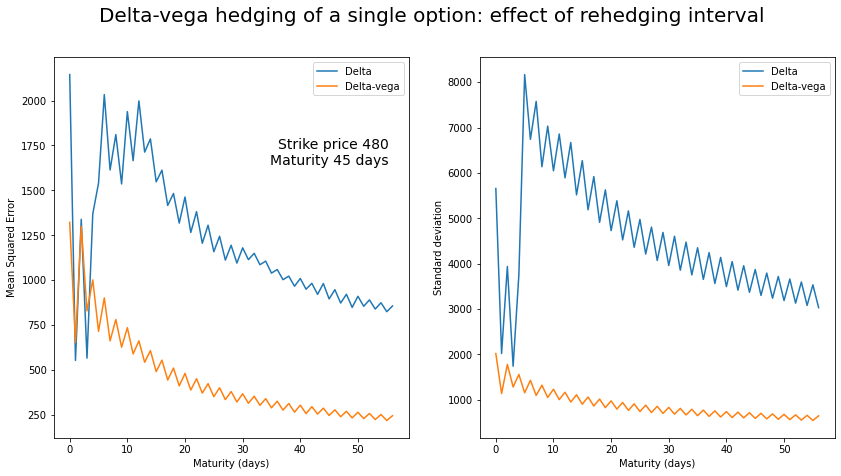

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Delta-vega hedging of a single option: effect of rehedging interval', fontsize=20)

ax1.set(xlabel="Maturity (days)", ylabel="Mean Squared Error")
ax1.plot(averages_delta, label = "Delta")
ax1.plot(averages_vega, label = "Delta-vega")
ax1.legend(loc = "best")
ax1.annotate('Strike price 480\nMaturity 45 days',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 300), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='top', fontsize=14)

ax2.set(xlabel="Maturity (days)", ylabel="Standard deviation")
ax2.plot(stds_delta, label = "Delta")
ax2.plot(stds_vega, label = "Delta-vega")
ax2.legend(loc = "best")